<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats2/blob/main/05_divergent_transitions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. サンプリングがうまくいかない場合の例
* 密度関数が非常にpeakyであるとき、サンプリングが上手くいかないことがある。
 * peakyになっている部分が、サンプリングによって全くカバーされなかったりする。
* この場合、reparameterizationを使うと、問題が解決することがある。
 * https://mc-stan.org/docs/2_26/stan-users-guide/reparameterization-section.html

## 5.0 準備

In [ ]:
!pip install arviz==0.10
!pip install pymc3==3.10

In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

SEED = 20210328

## 5.1 サンプリングがうまく行かない理由
* 参考資料
 * https://mc-stan.org/docs/2_26/reference-manual/divergent-transitions.html
* HMCは、勾配を使ってfirst-orderの近似を行っているため、"地形が急峻な"場所では、本当に求めたいものから大きく外れてしまうことがある。すると、サンプリングがパラメータ空間内での単なるランダムウォークに近くなってしまい、密度関数の"濃淡"を反映しないものになってしまう。
 * 別の参考資料 https://norimune.net/3149

## 5.2 例題
* 下のような確率分布を考える( https://mc-stan.org/docs/2_26/stan-users-guide/reparameterization-section.html )。
$$\begin{align} 
y & \sim N(0, 3^2) \\
x_i & \sim N(0, e^y), \text{ $i=1,\ldots, 9$ }  
\end{align}$$


* 同時分布を式で書くと・・・
$$p(y, x_1, \ldots, x_9) = p(y) \prod_{i=1}^9 p(x_i | y)$$
where
$$ p(y) = \frac{1}{\sqrt{2\pi 3^2}} \exp\bigg( - \frac{y^2}{2 \times 3^2}\bigg)  $$
and
$$ p(x_i | y) = \frac{1}{\sqrt{2\pi e^y}} \exp\bigg( - \frac{x_i^2}{2e^y} \bigg) $$

* この分布の問題点
 * $y$の値が小さいとき、$x_i$が従う正規分布が非常にpeakyな密度関数を持つことになり、サンプリングが困難になる。

* 今回は、この分布からサンプリングする。（つまり、この分布に従う乱数を発生させる。）
 * つまり、今日はベイズの話をするのではなく・・・
 * NUTSサンプラーでもうまくいかない場合がどんな場合かを、単に説明する。

### 5.2.1 実装方法 (1)
* これは悪い実装方法。
 * divergent transitionが発生する。
 * さらに、周辺分布$p(y)$は正規分布となるはずなのに、ヒストグラムが全く正規分布の形にならない。

In [3]:
with pm.Model() as model:
  y = pm.Normal("y", mu=0, sd=3)
  x = pm.Normal("x", mu=0, sd=(y/2).exp(), shape=9)

* 　今回は、`return_inferencedata=True`と設定せず、arviz向けではない形式、元のPyMC3の形式で、サンプリング結果を得る
 * arviz向けのサンプリング結果で同じようにdivergenceの分析を行う方法は後で説明する。

In [4]:
with model:
  trace = pm.sample(2000, cores=4, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, y]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6229251102014379, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6600310224029062, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [5]:
type(trace)

pymc3.backends.base.MultiTrace

In [6]:
trace['x'].shape

(8000, 9)

In [7]:
x0 = trace['x'][:,0]

In [8]:
x0.shape

(8000,)

In [9]:
y = trace['y']

In [10]:
y.shape

(8000,)

* divergenceとは

> "A divergence arises when the simulated Hamiltonian trajectory departs from the true trajectory as measured by departure of the Hamiltonian value from its initial value. When this divergence is too high, the simulation has gone off the rails and cannot be trusted. The positions along the simulated trajectory after the Hamiltonian diverges will never be selected as the next draw of the MCMC algorithm, potentially reducing Hamiltonian Monte Carlo to a simple random walk and biasing estimates by not being able to thoroughly explore the posterior distribution." ( https://mc-stan.org/docs/2_26/reference-manual/divergent-transitions.html )



* PyMC3でのdivergenceのチェック方法

In [11]:
divergent = trace['diverging']

In [12]:
divergent.shape

(8000,)

In [13]:
divergent

array([False, False, False, ..., False, False, False])

In [14]:
~ divergent

array([ True,  True,  True, ...,  True,  True,  True])

In [15]:
divergent.sum()

13

In [16]:
np.where(divergent)

(array([ 212, 1606, 2311, 2930, 2970, 3067, 3267, 3429, 3933, 5009, 5412,
        5442, 7145]),)

* chainの中でdivergenceが発生したサンプルを赤で示してみる。

Text(0.5, 1.0, 'scatter plot between y and x[0]')

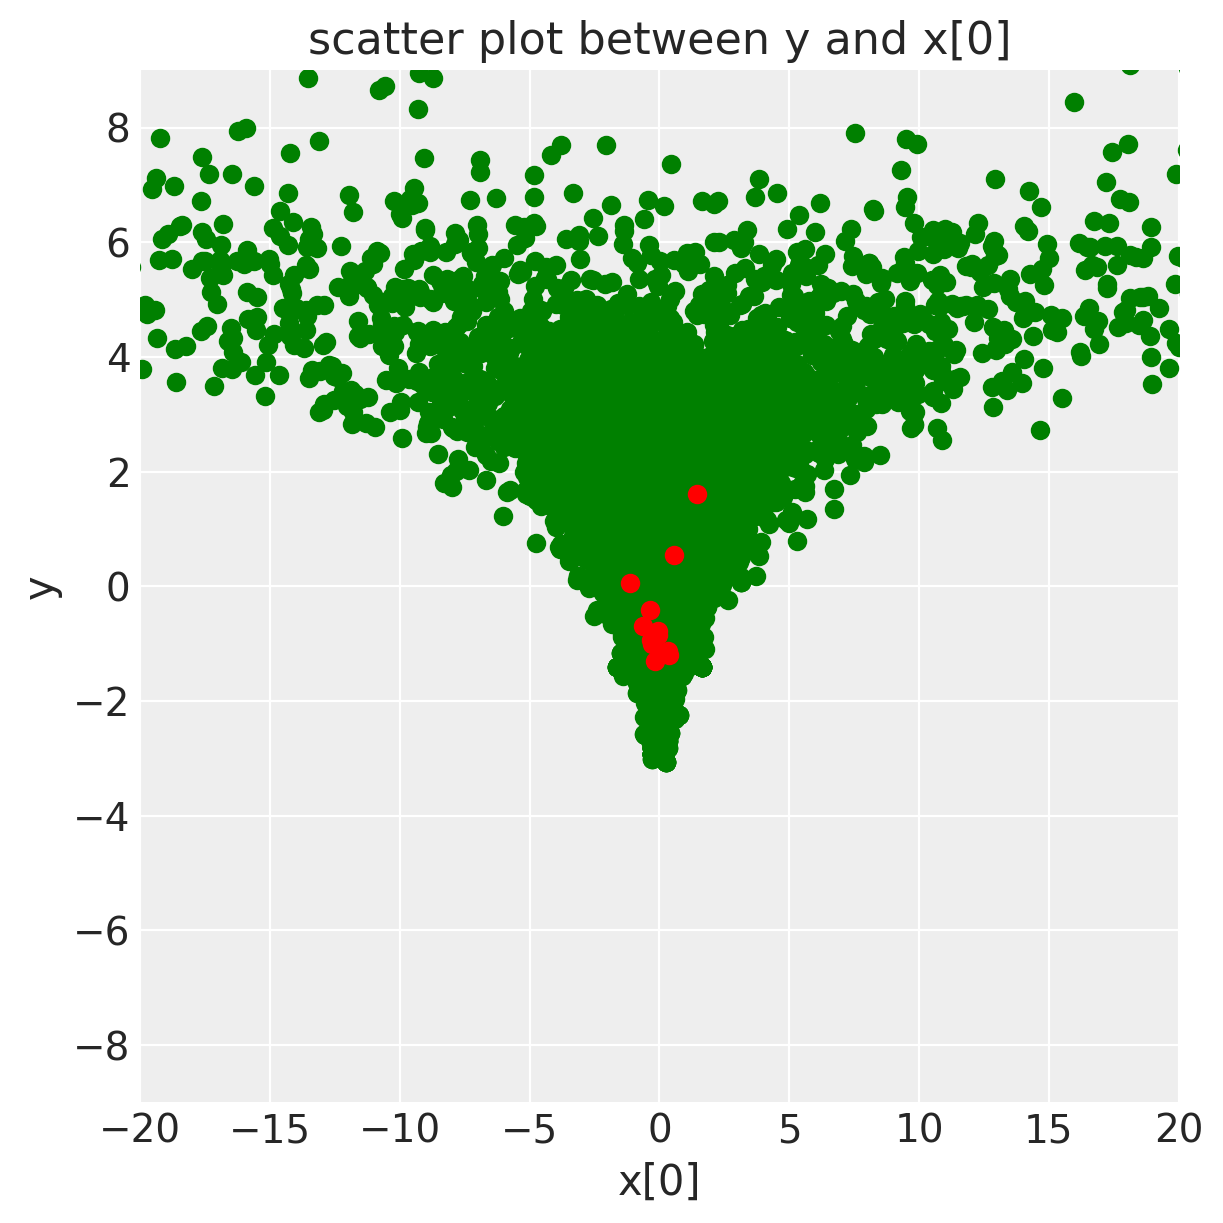

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(x0[~ divergent], y[~ divergent], color='g')
plt.scatter(x0[divergent], y[divergent], color='r')
plt.axis([-20, 20, -9, 9])
plt.ylabel('y')
plt.xlabel('x[0]')
plt.title('scatter plot between y and x[0]')

* 上のプロットで分かるように、図の下の方の領域で全くサンプルが取られていない。

* $y$のヒストグラムを確認する。
 * yの周辺分布は正規分布になるはずだが・・・

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


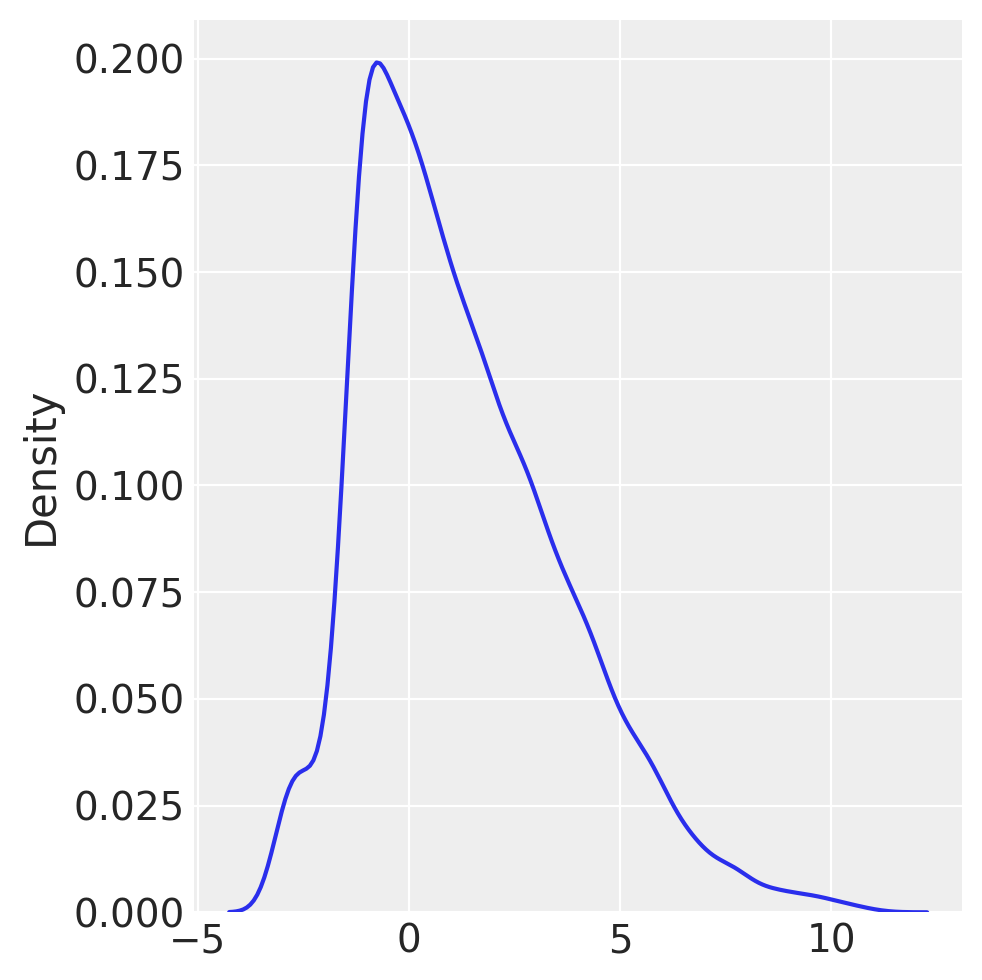

In [18]:
sns.displot(y, kind="kde")

### 5.2.2 実装方法 (2)
* これは、reparameterizationを使うことで改良された実装。
 * divergent transitionは起こらない。
 * $y$のサンプルのヒストグラムも正規分布の形を示す。

* 元のモデルは
$$\begin{align} 
y & \sim N(0, 3^2) \\
x_i & \sim N(0, e^y), \text{ $i=1,\ldots, 9$ }  
\end{align}$$


* $x_i$を$N(0, e^y)$からサンプリングする、という実装をやめて、代わりに
 * まず$x_\text{raw}$を$N(0,1)$からサンプリングし・・・
 * その$x_\text{raw}$を$x = e^{y/2} x_\text{raw}$という式で変換している。

In [19]:
with pm.Model() as model_revised:
  y = pm.Normal("y", mu=0, sd=3)
  x_raw = pm.Normal("x_raw", mu=0, sd=1, shape=9)
  x = pm.Deterministic("x", (y/2).exp() * x_raw)

In [20]:
with model_revised:
  trace_revised = pm.sample(2000, cores=4, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x_raw, y]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


In [21]:
x0 = trace_revised['x'][:, 0]
y = trace_revised['y']
divergent = trace_revised['diverging']

In [22]:
divergent.sum()

0

Text(0.5, 1.0, 'scatter plot between y and x[0]')

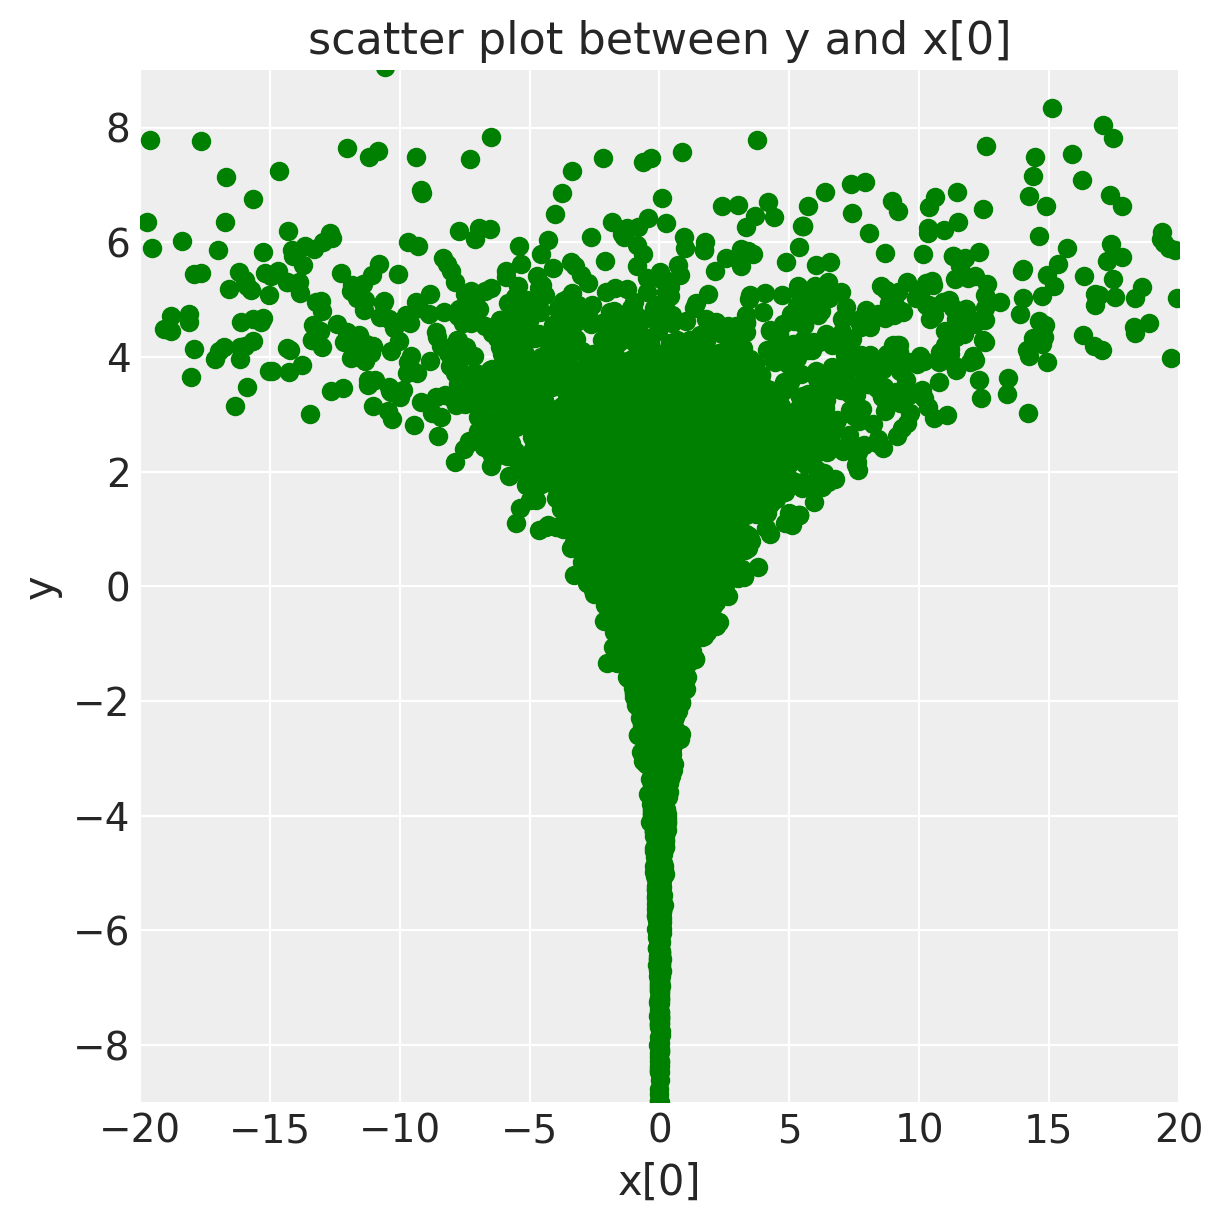

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(x0[~ divergent], y[~ divergent], color='g')
plt.scatter(x0[divergent], y[divergent], color='r')
plt.axis([-20, 20, -9, 9])
plt.ylabel('y')
plt.xlabel('x[0]')
plt.title('scatter plot between y and x[0]')

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


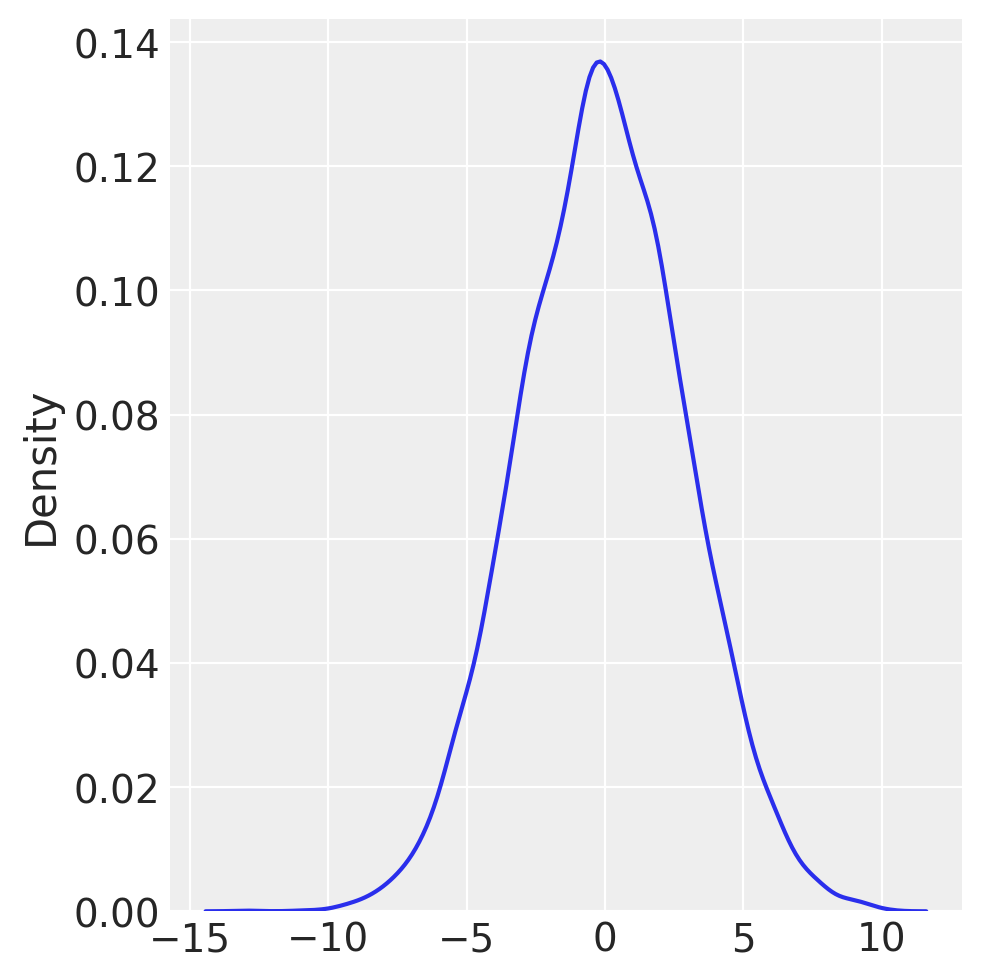

In [24]:
sns.displot(y, kind="kde")

## 5.3 The Eight Schools Model
* 下記Webページにある「A Centered Eight Schools Implementation」の実験を再現してみる。
 * https://pymc3.readthedocs.io/en/latest/notebooks/Diagnosing_biased_Inference_with_Divergences.html




> "Hamiltonian Monte Carlo, for example, is especially powerful in this regard as its failures to be geometrically ergodic with respect to any target distribution manifest in distinct behaviors that have been developed into sensitive diagnostics. One of these behaviors is the appearance of divergences that indicate the Hamiltonian Markov chain has encountered regions of high curvature in the target distribution which it cannot adequately explore." 
(https://pymc3.readthedocs.io/en/latest/notebooks/Diagnosing_biased_Inference_with_Divergences.html )



* arviz向けにコードを書き直した。

### 5.5.1 データセット
* `y`が観測データ
* `sigma`が既知のパラメータ

In [25]:
# Data of the Eight Schools Model
y = np.asarray([28,  8, -3,  7, -1,  1, 18, 12], dtype=float)
sigma = np.asarray([15, 10, 16, 11,  9, 11, 10, 18], dtype=float)
J = y.shape[0]

* このデータを以下のようにモデリングする。
$$\begin{align}
\mu & \sim N(0,5) \notag \\
\tau & \sim \text{Half-Cauchy}(5) \\
\theta_n & \sim N(\mu, \tau) \\
y_n & \sim N(\theta_n, \sigma_n^2)
\end{align}$$
 * $y_n$が上記コードの`y`に対応する。
 * $\sigma_n$が上記コードの`sigma`に対応する。

* Half-cauchy分布については下記ページを参照
 * https://distribution-explorer.github.io/continuous/halfcauchy.html
> "The Half-Cauchy distribution with 𝜇=0 is a useful prior for nonnegative parameters that may be very large, as allowed by the very heavy tails of the Half-Cauchy distribution."

### 5.5.2 実装方法(1)
* これは良くない実装方法。
 * reparameterizationを使って後で改良する。

In [26]:
with pm.Model() as Centered_eight:
  mu = pm.Normal('mu', mu=0, sd=5)
  tau = pm.HalfCauchy('tau', beta=5)
  theta = pm.Normal('theta', mu=mu, sd=tau, shape=J)
  obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

* `return_inferencedata=True`としてarviz向けのサンプリング結果データを得る。　

In [27]:
with Centered_eight:
  trace = pm.sample(2000, cores=4, random_seed=SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6370223215883811, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6144847592132275, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [28]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,4.143,3.376,-1.779,10.714,0.148,0.105,521.0,521.0,526.0,1005.0,1.02
theta[0],6.268,6.086,-4.308,17.987,0.197,0.139,956.0,956.0,719.0,2413.0,1.01
theta[1],4.753,4.943,-3.981,14.710,0.158,0.112,982.0,982.0,896.0,2798.0,1.00
theta[2],3.616,5.531,-6.848,14.255,0.153,0.108,1312.0,1312.0,1082.0,2203.0,1.01
theta[3],4.604,5.057,-4.581,14.594,0.150,0.106,1137.0,1137.0,997.0,2552.0,1.01
theta[4],3.235,4.871,-5.998,12.282,0.154,0.109,1001.0,1001.0,904.0,1894.0,1.01
theta[5],3.819,5.069,-5.292,14.069,0.149,0.105,1165.0,1165.0,1037.0,1941.0,1.01
theta[6],6.325,5.399,-3.717,16.512,0.197,0.139,753.0,753.0,655.0,895.0,1.01
theta[7],4.660,5.569,-5.413,15.749,0.136,0.096,1675.0,1675.0,1312.0,2548.0,1.01
tau,4.223,3.121,0.963,9.809,0.146,0.104,455.0,455.0,181.0,113.0,1.02


* `r_hat`は1.0に近いので問題なさそう。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d78e24790>,
      dtype=object)

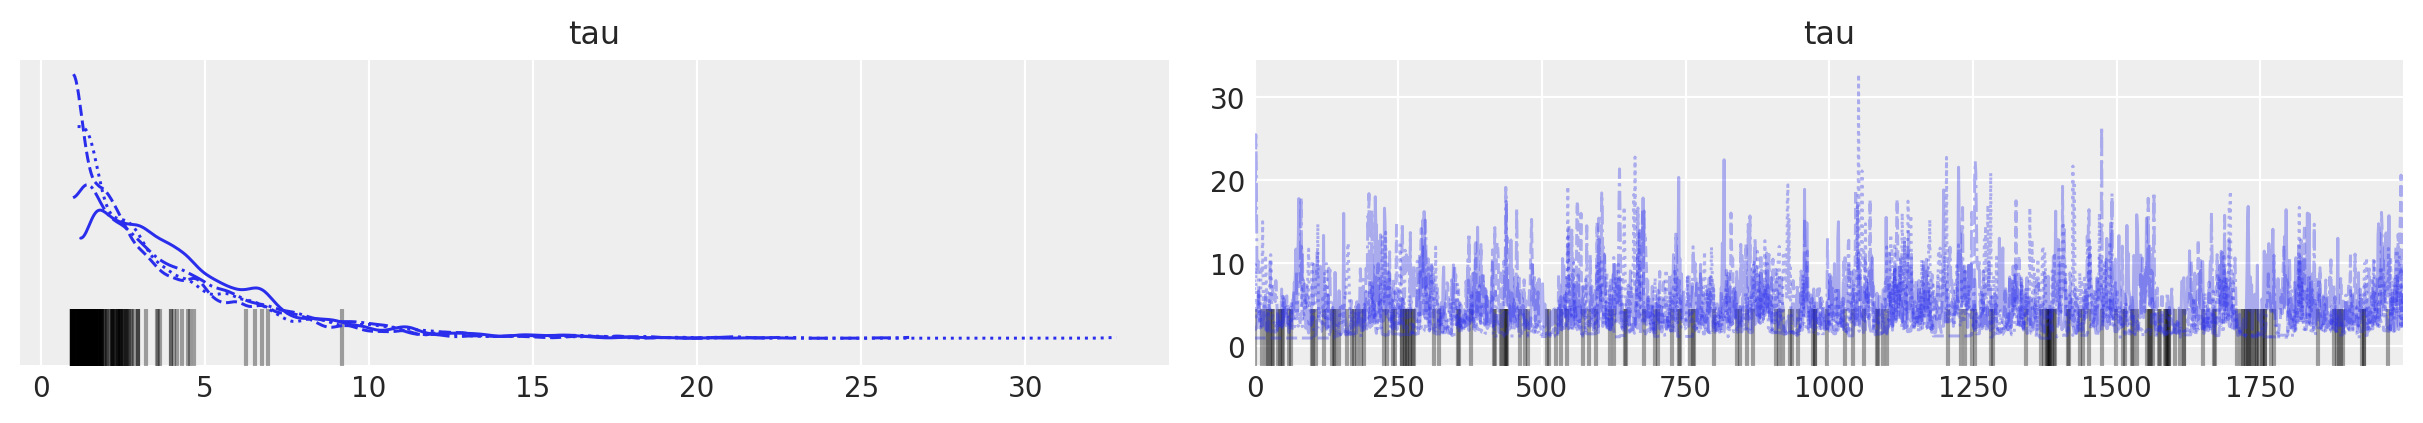

In [29]:
pm.traceplot(trace, var_names=['tau'])

* このデータについては$\tau$の真の値が分かっているらしい。
 * 詳細はよく知りません。（すいません。）
* logスケールでプロットして、真の値からのズレを見てみる。
 * $\log \tau$の真の値は0.7657852らしいです。

Text(0.5, 1.0, 'MCMC estimation of log(tau)')

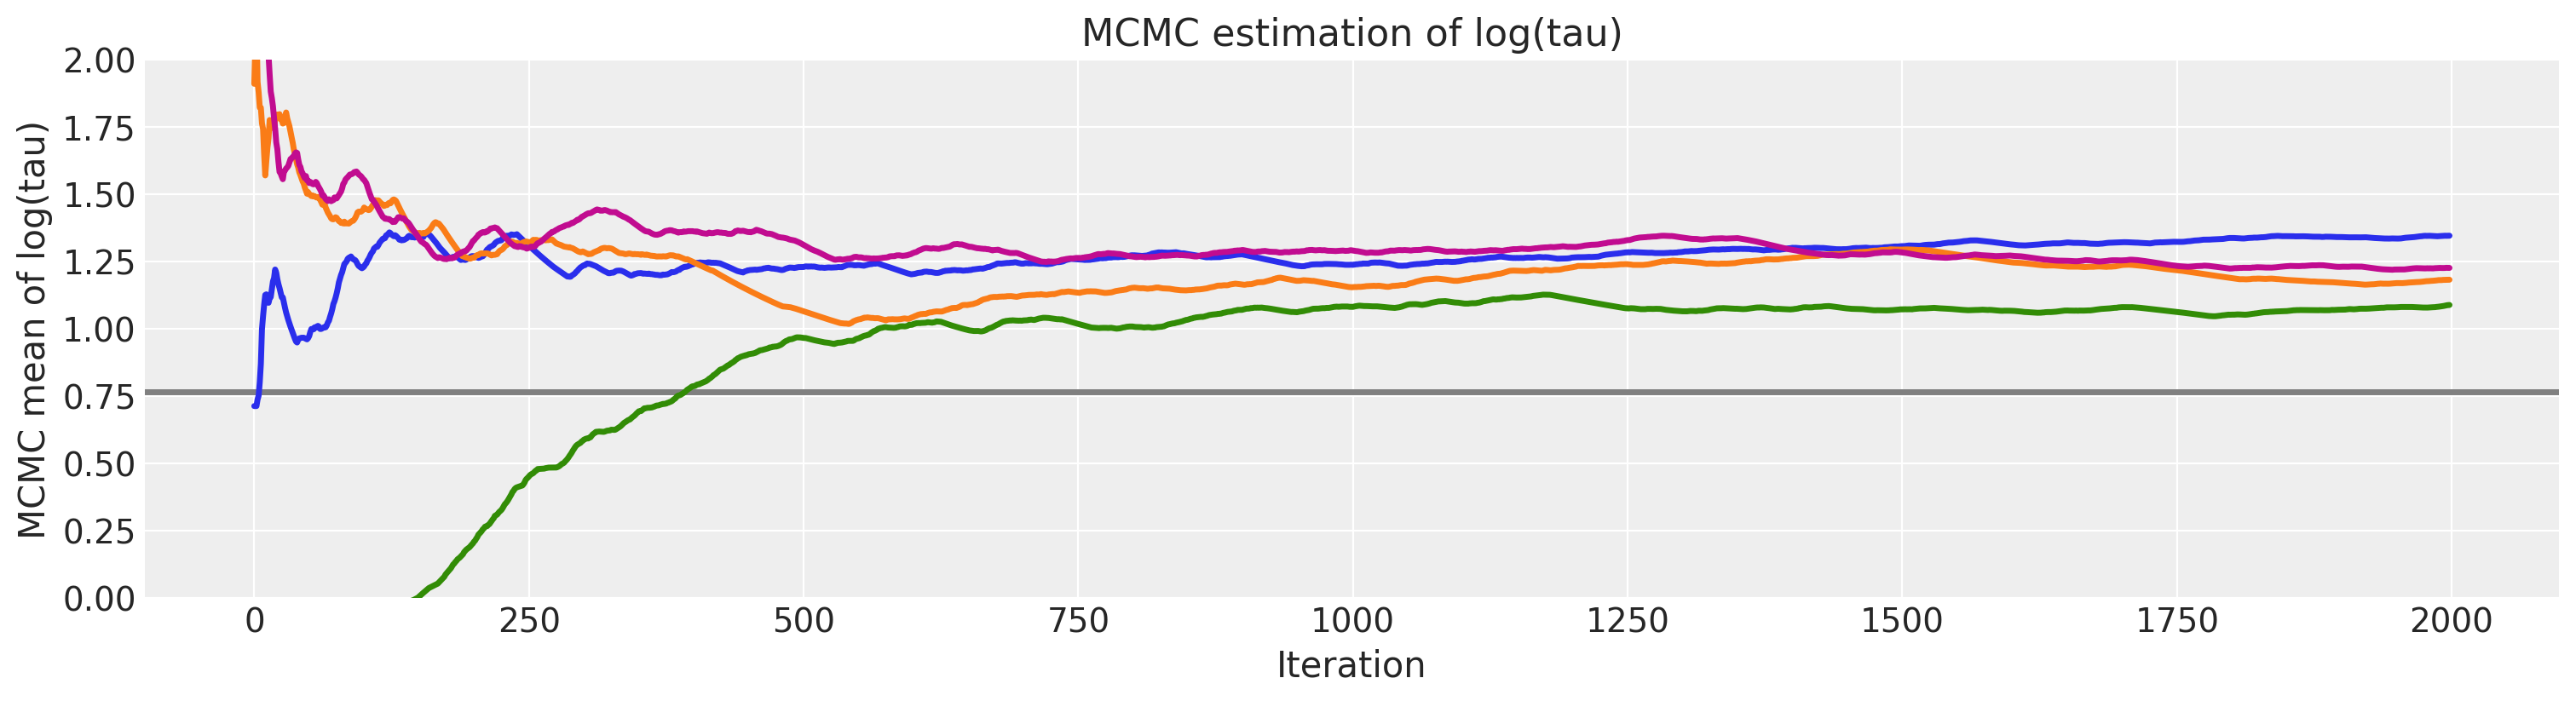

In [30]:
logtau = np.log(trace.posterior['tau'].data)
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
for j in range(logtau.shape[0]):
  mlogtau = [np.mean(logtau[j,:i]) for i in np.arange(1, len(logtau[j]))]
  plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')

In [31]:
trace.sample_stats

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 2000)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
Data variables: (12/13)
    step_size_bar       (chain, draw) float64 0.301 0.301 ... 0.3433 0.3433
    lp                  (chain, draw) float64 -51.06 -51.06 ... -52.29 -55.13
    energy_error        (chain, draw) float64 0.0 0.0 0.0 ... -0.3642 0.08066
    energy              (chain, draw) float64 54.78 55.16 57.46 ... 59.05 58.27
    perf_counter_diff   (chain, draw) float64 0.004931 0.004252 ... 0.00359
    depth               (chain, draw) int64 3 3 2 4 2 4 3 3 ... 4 3 3 3 3 3 3 4
    ...                  ...
    process_time_diff   (chain, draw) float64 0.002969 0.002528 ... 0.00359
    step_size           (chain, draw) float64 0.1919 0.1919 ... 0.4296 0.4296
    tree_size           (chain, draw) float64 7.0 7.0 3.0 11.0 ... 7.0 7.0 15.0
    mean_tree_accept    (chain, draw) float64 0.1813 0.04889 ... 0.9698 0.9183
    diverging           (chain, draw) bool False False False ... False False
    max_energy_error    (chain, draw) float64 6.811 65.73 18.7 ... -0.3642 29.28
Attributes:
    created_at:                 2021-05-16T04:40:57.952895
    arviz_version:              0.10.0
    inference_library:          pymc3
    inference_library_version:  3.10.0
    sampling_time:              24.31164240837097
    tuning_steps:               1000

In [32]:
trace.sample_stats.diverging

<xarray.DataArray 'diverging' (chain: 4, draw: 2000)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

In [33]:
chain_id = 0
divergent = trace.sample_stats.diverging.data[chain_id]

Text(0.5, 1.0, 'scatter plot between log(tau) and theta[0]')

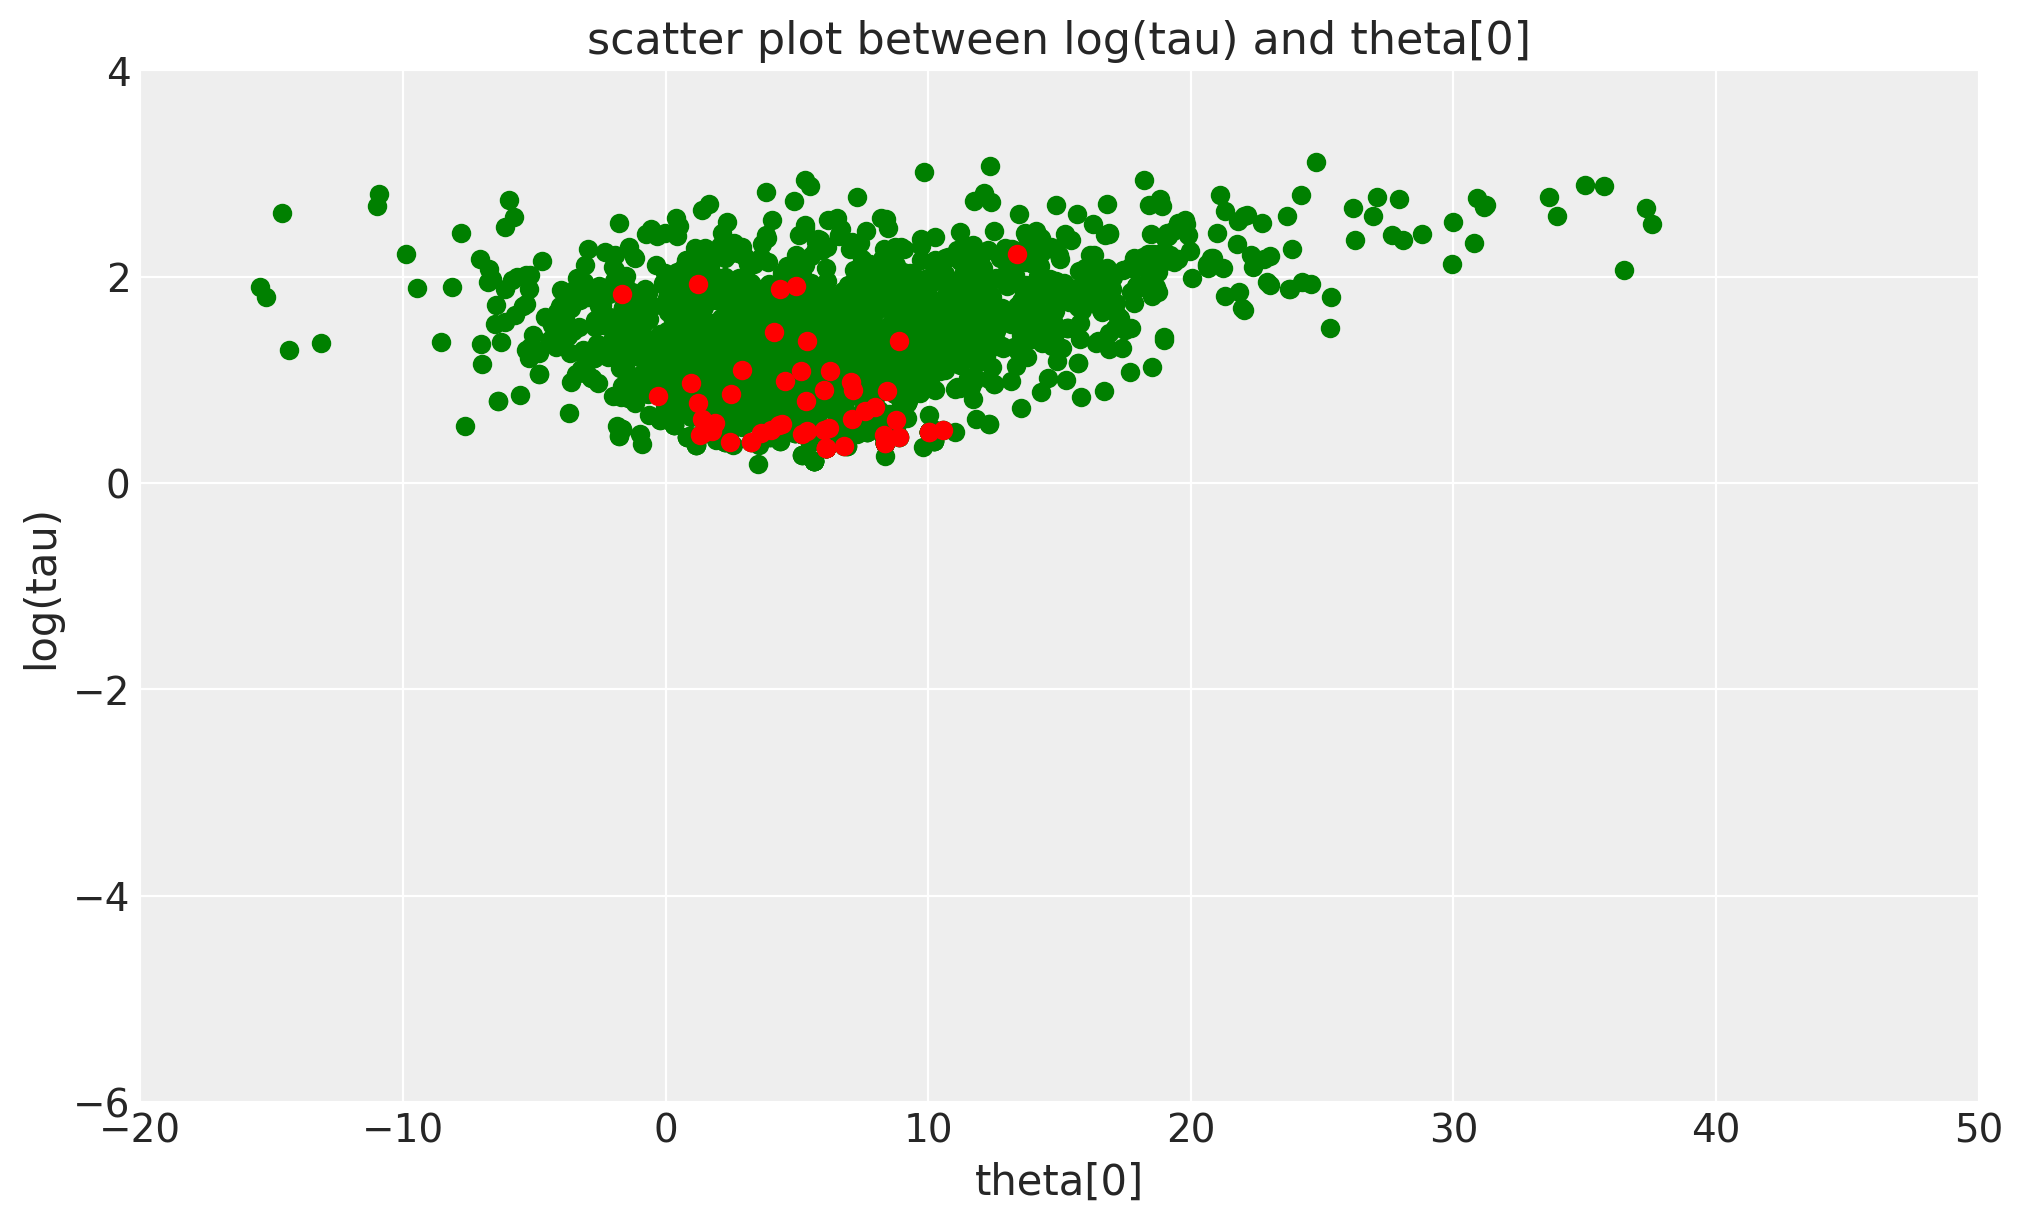

In [34]:
theta_trace = trace.posterior['theta'][chain_id]
theta0 = theta_trace[:,0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[~divergent], logtau[chain_id][~divergent], color='g')
plt.scatter(theta0[divergent], logtau[chain_id][divergent], color='r')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')

Text(0.5, 1.0, 'scatter plot between log(tau) and theta[0]')

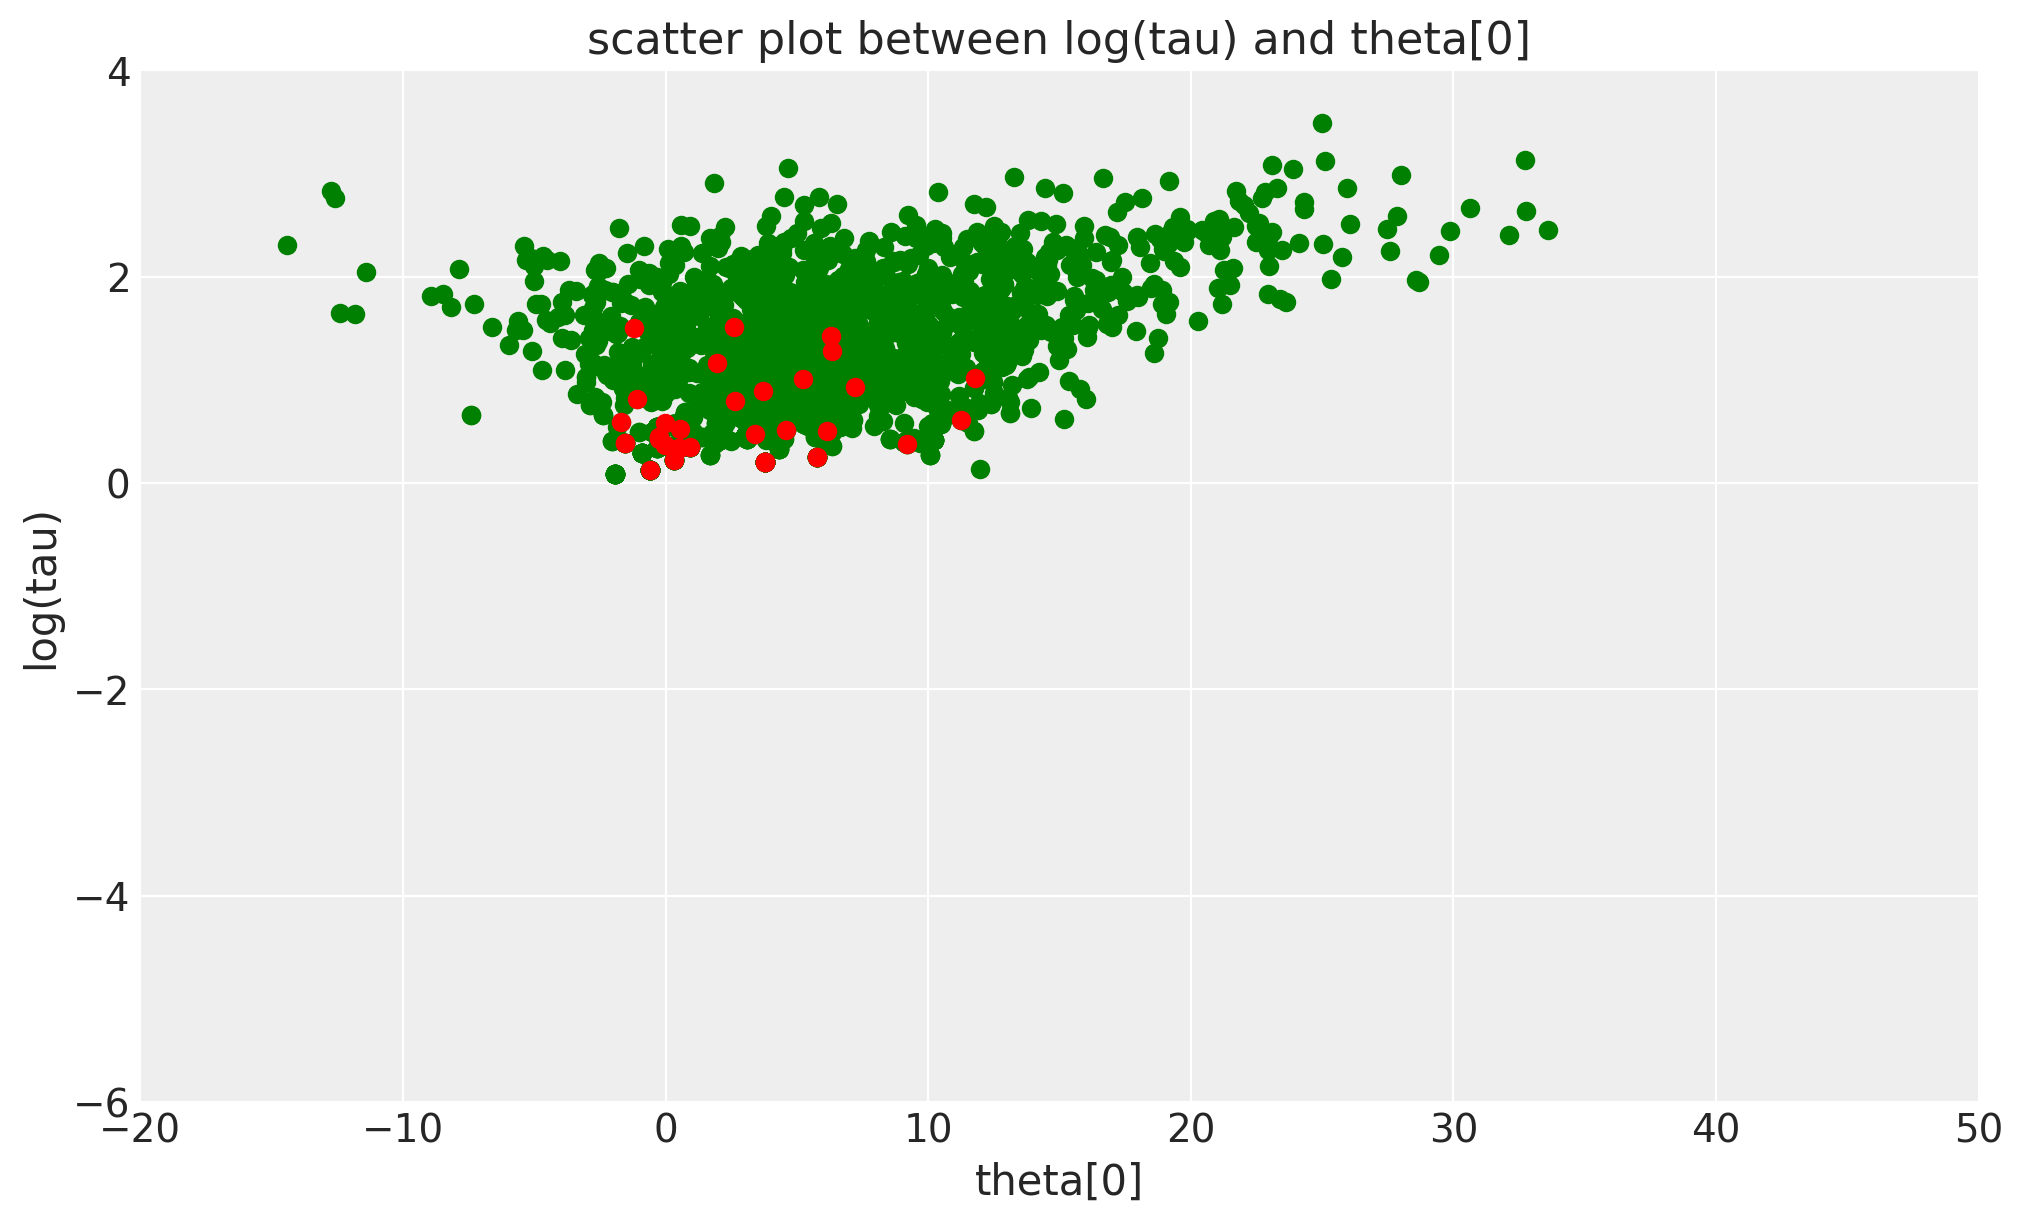

In [35]:
chain_id = 1
divergent = trace.sample_stats.diverging.data[chain_id]
theta_trace = trace.posterior['theta'][chain_id]
theta0 = theta_trace[:,0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[~divergent], logtau[chain_id][~divergent], color='g')
plt.scatter(theta0[divergent], logtau[chain_id][divergent], color='r')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')

### 5.5.3 実装方法(2)
* reparameterizationを使う。

In [36]:
with pm.Model() as NonCentered_eight:
  mu = pm.Normal('mu', mu=0, sd=5)
  tau = pm.HalfCauchy('tau', beta=5)
  theta_tilde = pm.Normal('theta_t', mu=0, sd=1, shape=J)
  theta = pm.Deterministic('theta', mu + tau * theta_tilde) # ここでreparameterizationを使用
  obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [37]:
with NonCentered_eight:
  trace = pm.sample(2000, cores=4, random_seed=SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_t, tau, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


In [38]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,4.381,3.373,-1.857,10.782,0.042,0.031,6394.0,5804.0,6398.0,3503.0,1.0
theta_t[0],0.313,0.995,-1.531,2.152,0.011,0.012,8133.0,3686.0,8139.0,5199.0,1.0
theta_t[1],0.099,0.938,-1.659,1.853,0.010,0.011,8215.0,3563.0,8202.0,5003.0,1.0
theta_t[2],-0.078,0.971,-1.986,1.692,0.011,0.012,8327.0,3528.0,8332.0,5179.0,1.0
theta_t[3],0.049,0.940,-1.702,1.798,0.010,0.011,8708.0,3584.0,8771.0,5644.0,1.0
theta_t[4],-0.152,0.955,-1.948,1.638,0.010,0.012,8951.0,3217.0,8937.0,4798.0,1.0
theta_t[5],-0.059,0.917,-1.806,1.636,0.010,0.011,8624.0,3422.0,8622.0,5443.0,1.0
theta_t[6],0.372,0.948,-1.380,2.134,0.011,0.011,7830.0,4032.0,7810.0,5318.0,1.0
theta_t[7],0.080,0.987,-1.765,1.966,0.010,0.012,8984.0,3243.0,8960.0,5378.0,1.0
tau,3.658,3.154,0.000,9.339,0.049,0.036,4174.0,3781.0,3892.0,3392.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d67b0d0d0>,
      dtype=object)

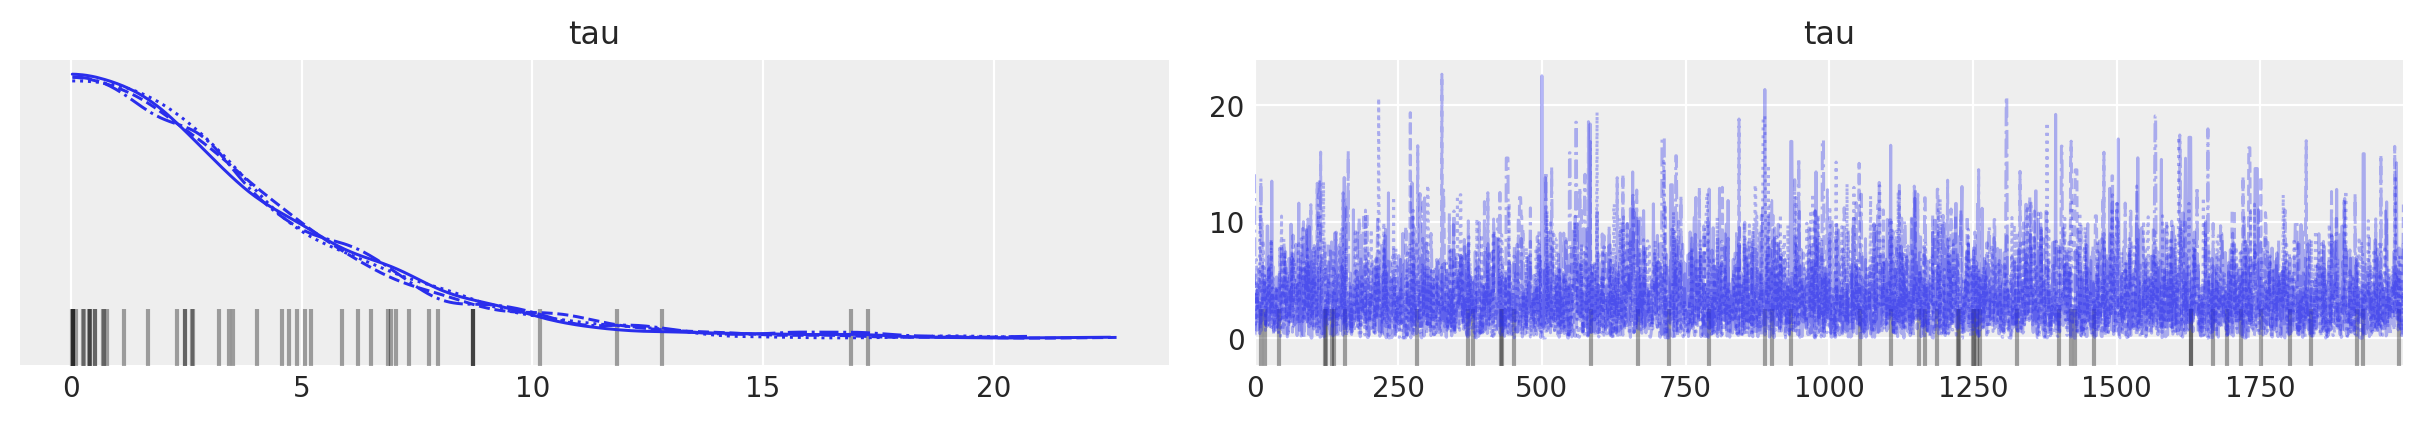

In [39]:
pm.traceplot(trace, var_names=['tau'])

Text(0.5, 1.0, 'MCMC estimation of log(tau)')

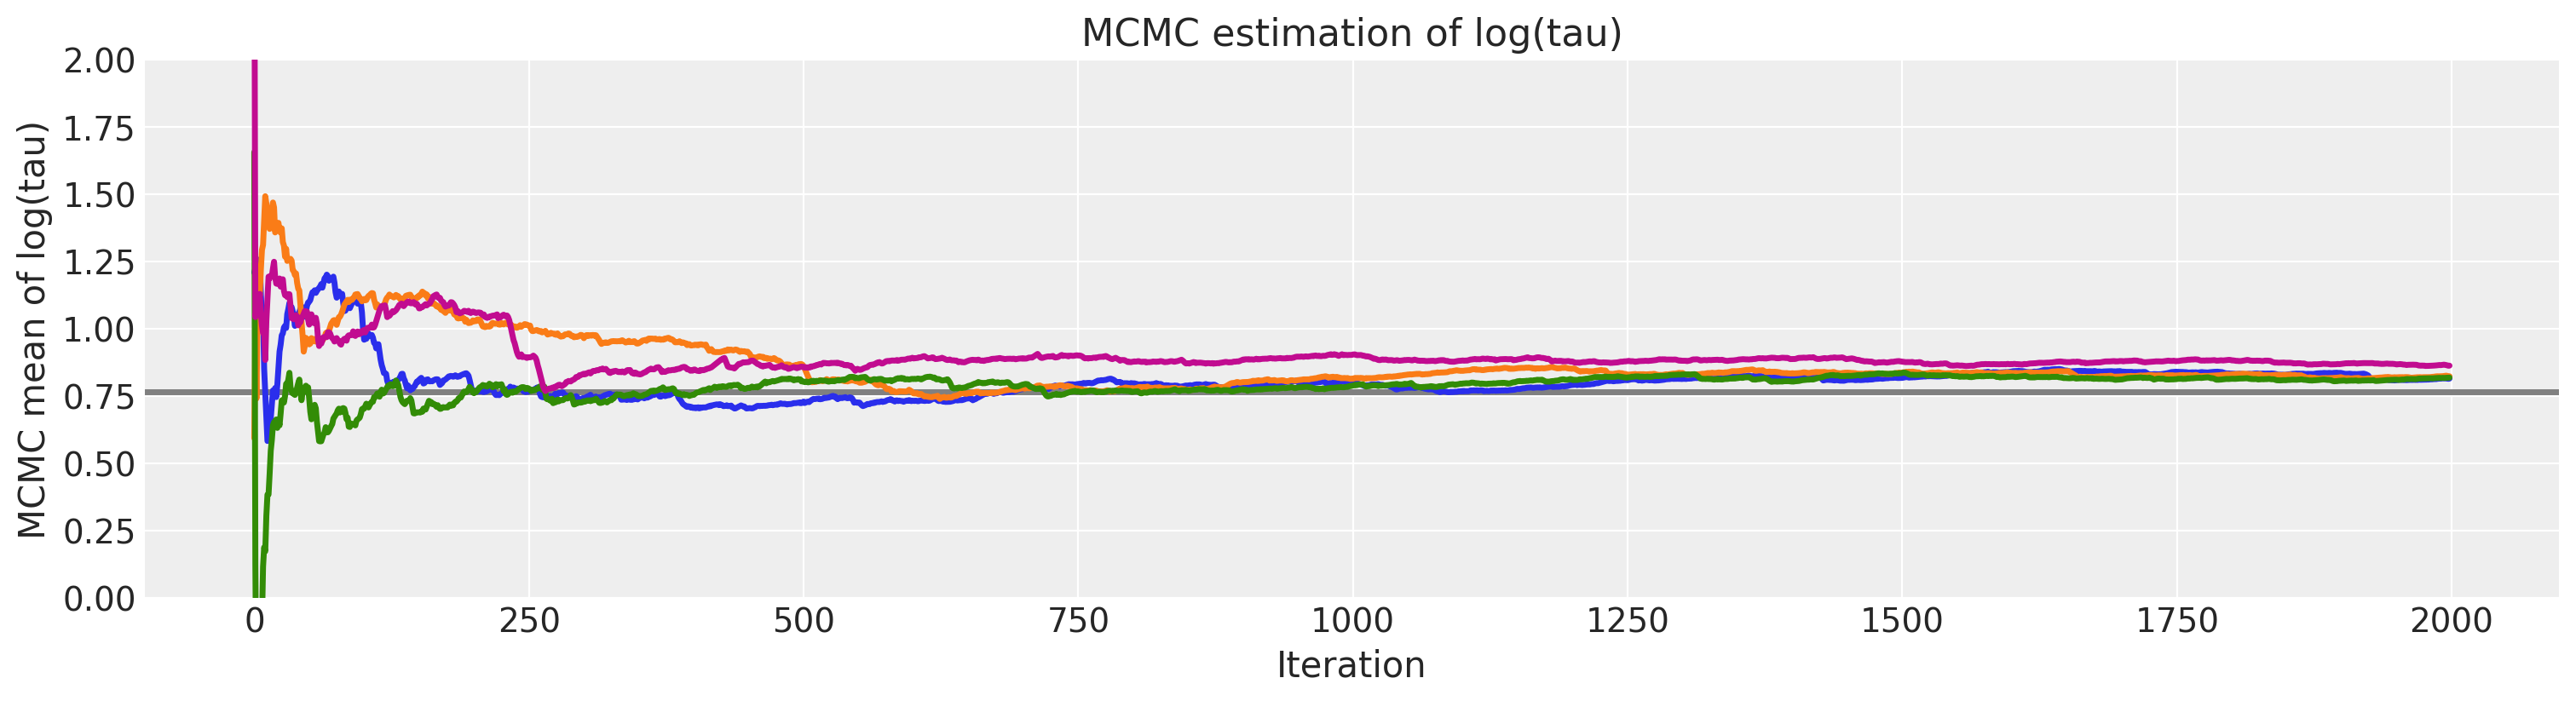

In [40]:
logtau = np.log(trace.posterior['tau'].data)
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
for j in range(logtau.shape[0]):
  mlogtau = [np.mean(logtau[j,:i]) for i in np.arange(1, len(logtau[j]))]
  plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')

Text(0.5, 1.0, 'scatter plot between log(tau) and theta[0]')

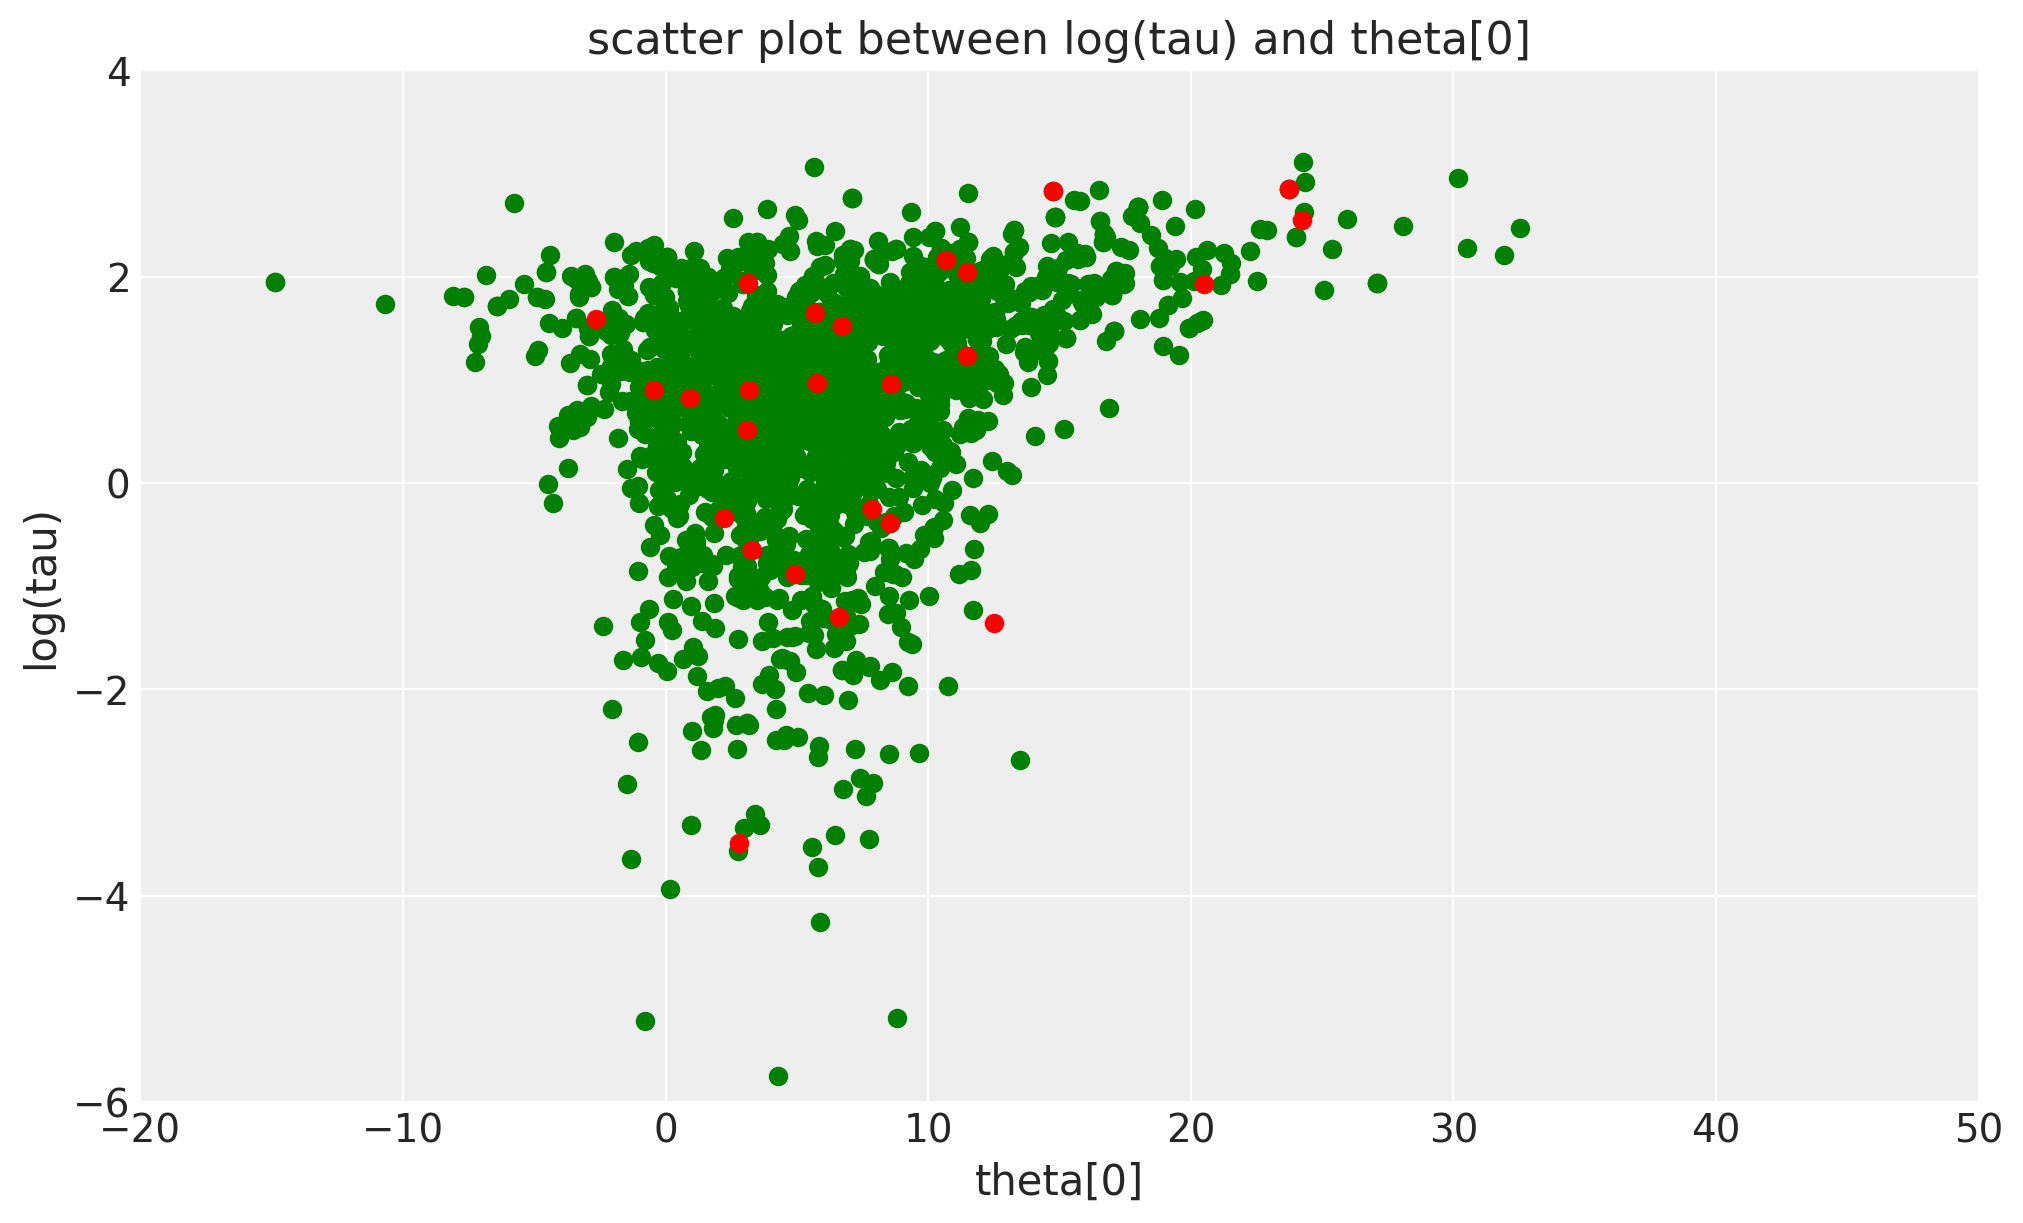

In [41]:
chain_id = 0
divergent = trace.sample_stats.diverging.data[chain_id]
theta_trace = trace.posterior['theta'][chain_id]
theta0 = theta_trace[:,0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[~divergent], logtau[chain_id][~divergent], color='g')
plt.scatter(theta0[divergent], logtau[chain_id][divergent], color='r')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')

Text(0.5, 1.0, 'scatter plot between log(tau) and theta[0]')

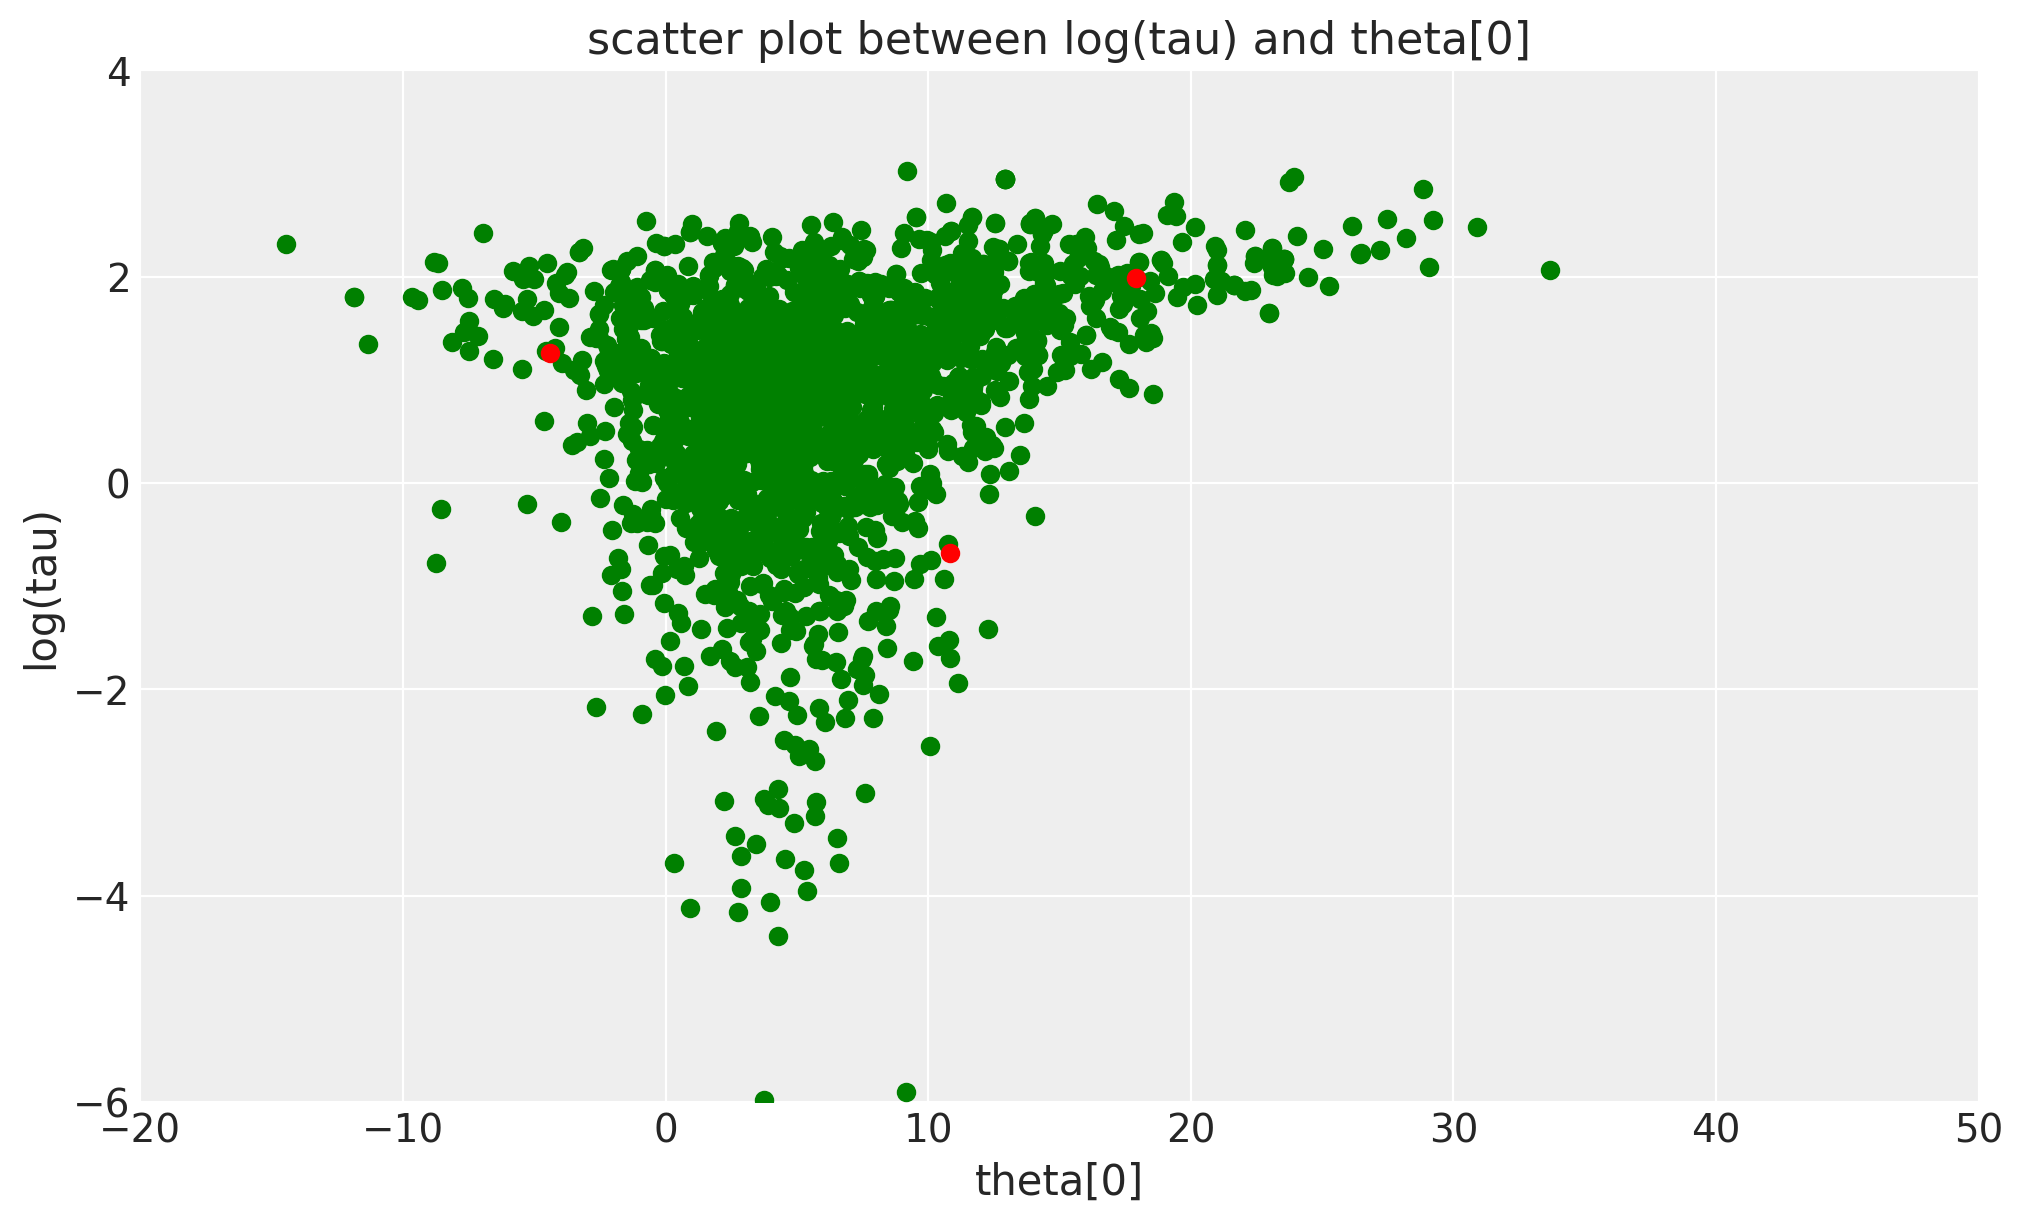

In [42]:
chain_id = 1
divergent = trace.sample_stats.diverging.data[chain_id]
theta_trace = trace.posterior['theta'][chain_id]
theta0 = theta_trace[:,0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[~divergent], logtau[chain_id][~divergent], color='g')
plt.scatter(theta0[divergent], logtau[chain_id][divergent], color='r')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')

### 5.5.4 採択率(acceptance rate)を調整する

> "target_accept : float in [0, 1]. The step size is tuned such that we approximate this acceptance rate. Higher values like 0.9 or 0.95 often work better for problematic posteriors." (https://docs.pymc.io/api/inference.html ) 


In [44]:
with NonCentered_eight:
  step = pm.NUTS(target_accept=.90)
  trace = pm.sample(2000, step=step, cores=4, random_seed=SEED, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_t, tau, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [45]:
with NonCentered_eight:
  step = pm.NUTS(target_accept=.95)
  trace = pm.sample(2000, step=step, cores=4, random_seed=SEED, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_t, tau, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


In [46]:
with NonCentered_eight:
  step = pm.NUTS(target_accept=1.0)
  trace = pm.sample(2000, step=step, cores=4, random_seed=SEED, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_t, tau, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.
The acceptance probability does not match the target. It is 0.9971561924606606, but should be close to 1.0. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.997538534045532, but should be close to 1.0. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9974665769038705, but should be close to 1.0. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.997318152913714, but should be close to 1.0. Try to increase the number of tuning steps.


Text(0.5, 1.0, 'MCMC estimation of log(tau)')

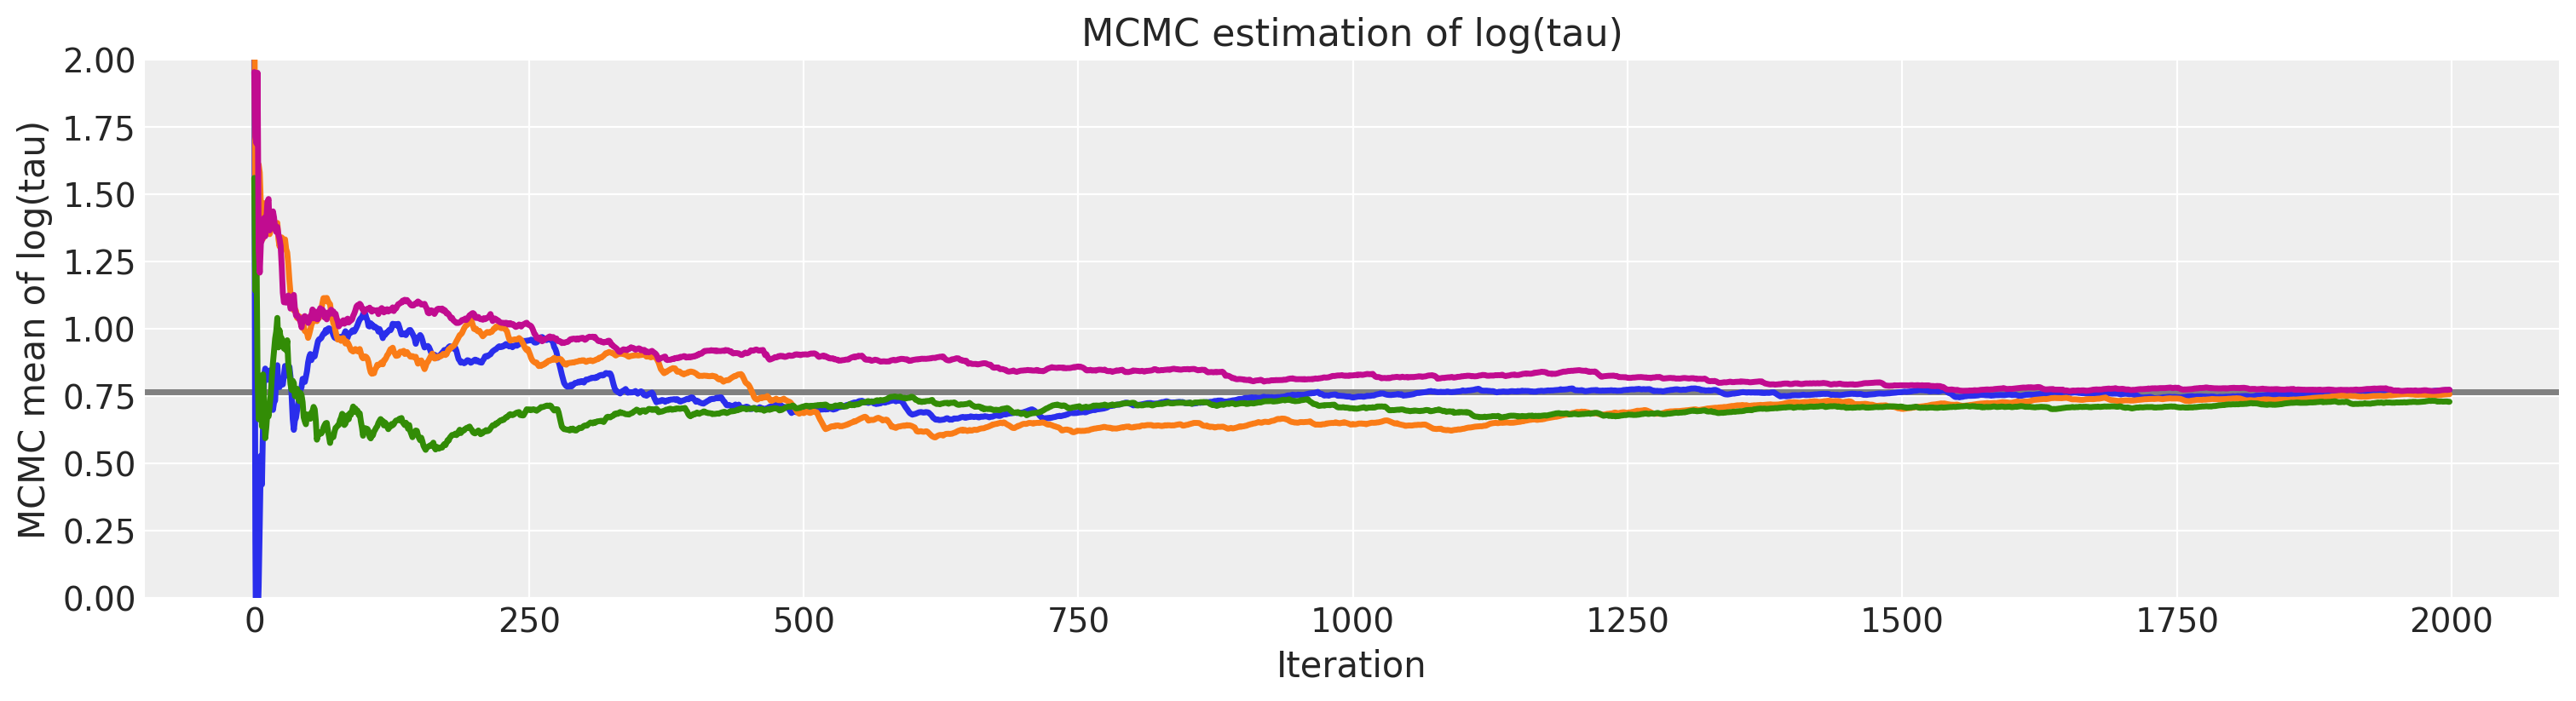

In [47]:
logtau = np.log(trace.posterior['tau'].data)
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
for j in range(logtau.shape[0]):
  mlogtau = [np.mean(logtau[j,:i]) for i in np.arange(1, len(logtau[j]))]
  plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')